In [21]:
! pip install -q kaggle

In [22]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"armankizatov","key":"9ec6bd9c97096b18d00bb9fbb00805a0"}'}

In [23]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [24]:
! chmod 600 ~/.kaggle/kaggle.json

In [25]:
! kaggle datasets download -d uciml/iris

  0% 0.00/3.60k [00:00<?, ?B/s]
100% 3.60k/3.60k [00:00<00:00, 3.09MB/s]


In [27]:
! unzip iris.zip

Archive:  iris.zip
replace Iris.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Iris.csv                
  inflating: database.sqlite         


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

# set seaborn
sns.set()

In [30]:
iris_csv_path = "/content/Iris.csv"

iris = pd.read_csv(iris_csv_path)

iris.head

<bound method NDFrame.head of       Id  SepalLengthCm  ...  PetalWidthCm         Species
0      1            5.1  ...           0.2     Iris-setosa
1      2            4.9  ...           0.2     Iris-setosa
2      3            4.7  ...           0.2     Iris-setosa
3      4            4.6  ...           0.2     Iris-setosa
4      5            5.0  ...           0.2     Iris-setosa
..   ...            ...  ...           ...             ...
145  146            6.7  ...           2.3  Iris-virginica
146  147            6.3  ...           1.9  Iris-virginica
147  148            6.5  ...           2.0  Iris-virginica
148  149            6.2  ...           2.3  Iris-virginica
149  150            5.9  ...           1.8  Iris-virginica

[150 rows x 6 columns]>

In [31]:
dataset = iris.drop(['Species','Id'],axis = 1)
dataset.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [32]:
from sklearn.preprocessing import StandardScaler

standard = StandardScaler()
cleanDataSet = pd.DataFrame(standard.fit_transform(dataset))
cleanDataSet.head()

,0,1,2,3
0,-0.900681,1.032057,-1.341272,-1.312977
1,-1.143017,-0.124958,-1.341272,-1.312977
2,-1.385353,0.337848,-1.398138,-1.312977
3,-1.506521,0.106445,-1.284407,-1.312977
4,-1.021849,1.263460,-1.341272,-1.312977


In [40]:
from math import sqrt
import numpy as np
from collections import defaultdict, Counter
from numpy import (array, unravel_index, nditer, linalg, random, subtract, max,
                   power, exp, pi, zeros, ones, arange, outer, meshgrid, dot,
                   logical_and, mean, std, cov, argsort, linspace, transpose,
                   einsum, prod, nan, sqrt, hstack, diff, argmin, multiply)


def _build_iteration_indexes(data_len, num_iterations,
                             verbose=False, random_generator=None):
    """Returns an iterable with the indexes of the samples
    to pick at each iteration of the training.
    If random_generator is not None, it must be an instalce
    of numpy.random.RandomState and it will be used
    to randomize the order of the samples."""
    iterations = arange(num_iterations) % data_len
    if random_generator:
        random_generator.shuffle(iterations)
    if verbose:
        return _wrap_index__in_verbose(iterations)
    else:
        return iterations

def fast_norm(x):
  return sqrt(dot(x, x.T))


def asymptotic_decay(learning_rate, t, max_iter):
  return learning_rate / (1+t/(max_iter/2))


class Som(object):

  def __init__(self, x, y, input_len, sigma=1.0, learning_rate=0.5,
               decay_function=asymptotic_decay, neighborhood_function='gaussian',
               topology='rectangular', activation_distance='euclidean', 
               random_seed=None):
    if sigma >= x or sigma >= y:
      print("Sigma is too big for dimension of map.")
    
    self._random_generator = np.random.RandomState(random_seed)

    self._learning_rate = learning_rate
    self._sigma = sigma
    self._input_len = input_len

    self._weights = self._random_generator.rand(x, y, input_len)*2-1
    self._weights /= np.linalg.norm(self._weights, axis=-1, keepdims=True)

    self._activaton_map = np.zeros((x,y))
    self._neigx = np.arange(x)
    self._neigy = np.arange(y)


    self.topology = topology
    self._xx, self._yy = np.meshgrid(self._neigx, self._neigy)
    self._xx = self._xx.astype(float)
    self._yy = self._yy.astype(float)

    self._decay_function = decay_function

    neig_functions = {'gaussian': self._gaussian}
    
    self.neighborhood = neig_functions[neighborhood_function]

    distance_functions = {'euclidean': self._euclidean_distance}

    self._activation_distance = distance_functions[activation_distance]

  
  def get_weights(self):
    return self._weights

  def get_euclidean_coordinates(self):
    return self._xx.T, self._yy.T

  def convert_map_to_euclidean(self, xy):
    return self._xx.T[xy], self._yy.T[xy]

  def _activate(self, x):
    self._activation_map = self._activation_distance(x, self._weights)

  def activate(self, x):
    self._activate(x)
    return self._activaton_map

  def _gaussian(self, c, sigma):
    d = 2*(np.pi)*sigma*sigma
    ax = exp(-power(self._xx-self._xx.T[c], 2)/d)
    ay = exp(-power(self._yy-self._yy.T[c], 2)/d)
    return (ax*ay).T
  
  def _euclidean_distance(self, x, w):
    return np.linalg.norm(np.subtract(x,w), axis=-1)

  def winner(self, x):
    self._activate(x)
    return np.unravel_index(self._activation_map.argmin(),
                            self._activation_map.shape)
    
  def update(self, x, win, t, max_iteration):
    eta = self._decay_function(self._learning_rate, t, max_iteration)
    sig = self._decay_function(self._sigma, t, max_iteration)
    g = self.neighborhood(win, sig)*eta
    self._weights += einsum('ij, ijk->ijk', g, x-self._weights)

  def quantization(self, data):
    winners_coords = argmin(self._distance_from_weights(data), axis=1)
    return self._weights[unravel_index(winners_coords, self._weights.shape[:2])]

  def random_weights_init(self, data):
    it = nditer(self._activation_map, flags=['multi_index'])
    while not it.finished:
      rand_i = self._random_generator.randin(len(data))
      self._weights[it.multi_index] = data[rand_i]
      it.iternext()

  def train(self, data, num_iteration, random_order=False, verbose=False):
    random_generator=None
    if random_order:
      random_generator = self._random_generator
    iterations = _build_iteration_indexes(len(data), num_iteration,
                                          verbose, random_generator)
    
    for t, iteration in enumerate(iterations):
      self.update(data[iteration], self.winner(data[iteration]),
                  t, num_iteration)

  def train_random(self, data, num_iteration, verbose=False):
    self.train(data, num_iteration, random_order=True, verbose=verbose)

  def train_batch(self, data, num_iteration, verbose=False):
    self.train(data, num_iteration, random_order=False, verbose=verbose)

  def distance_map(self):
    um = zeros((self._weights.shape[0],
                self._weights.shape[1],
                8))
    ii = [[0, -1, -1, -1, 0, 1, 1, 1]]*2 
    jj = [[-1, -1, 0, 1, 1, 1, 0, -1]]*2

    if self.topology == 'hexagonal':
      ii = [[1, 1, 1, 0, -1, 0], [0, 1, 0, -1, -1, -1]]
      jj = [[1, 0, -1, -1, 0, 1], [1, 0, -1, -1, 0, 1]]

    for x in range(self._weights.shape[0]):
      for y in range(self._weights.shape[1]):
        w_2 = self._weights[x,y]
        e = y%2 == 0
        for k, (i, j) in enumerate(zip(ii[e], jj[e])):
          if (x+i >= 0 and x+i < self._weights.shape[0] and 
                y+j >= 0 and y+j < self._weights.shape[1]):
              w_1 = self._weights[x+i, y+j]
              um[x, y, k] = fast_norm(w_2 - w_1)
    um = um.sum(axis=2)
    return um/um.max()

  def activation_response(self, data):
    a = zeros((self._weights.shape[0], self._weights.shape[1]))
    for x in data:
      a[self.winner(x)] += 1
    return a

  def _distance_from_weights(self, data):   
    input_data = array(data)
    weights_flat = self._weights.reshape(-1, self._weights.shape[2])
    input_data_sq = power(input_data, 2).sum(axis=1, keepdims=True)
    weights_flat_sq = power(weights_flat, 2).sum(axis=1, keepdims=True)
    cross_term = dot(input_data, weights_flat.T)
    return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)

  def win_map(self, data, return_indices=False):
    winmap = defaultdict(list)
    for i, x in enumerate(data):
        winmap[self.winner(x)].append(i if return_indices else x)
    return winmap

  def labels_map(self, data, labels):
    winmap = defaultdict(list)
    for x, l in zip(data, labels):
        winmap[self.winner(x)].append(l)
    for position in winmap:
        winmap[position] = Counter(winmap[position])
    return winmap
         

In [41]:
som = Som(7, 7, 4, sigma=0.25, neighborhood_function='gaussian')
som.train_random(cleanDataSet.to_numpy(), 30000)

In [43]:
from matplotlib.gridspec import GridSpec

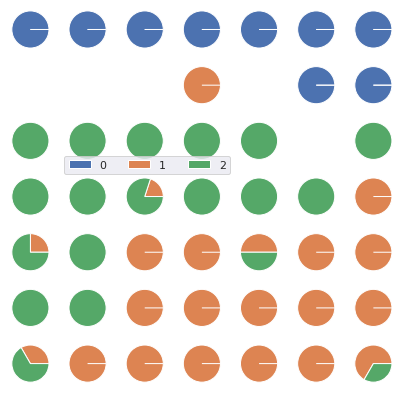

In [44]:
target = iris.Species.astype('category').cat.codes
labels_map = som.labels_map(cleanDataSet.to_numpy(), target)
label_names = np.unique(target)

plt.figure(figsize=(7, 7))
the_grid = GridSpec(7, 7)

for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.legend(patches, label_names, bbox_to_anchor=(0, 1.5), ncol=3)

plt.show()

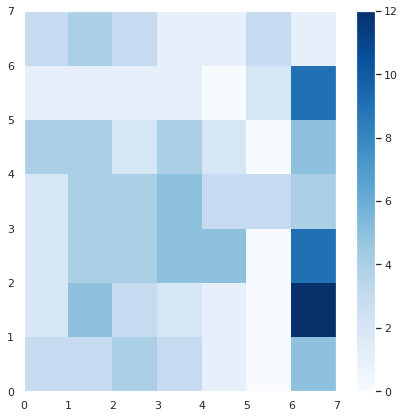

In [45]:
plt.figure(figsize=(7, 7))
frequencies = np.zeros((7, 7))
for position, values in som.win_map(cleanDataSet.to_numpy()).items():
    frequencies[position[0], position[1]] = len(values)
plt.pcolor(frequencies, cmap='Blues')
plt.colorbar()
plt.show()

Source: https://github.com/cgorman/tensorflow-som/blob/tfv2/tf_som.py